## Problem Description
The TSP can be defined as follows: for a given list of cities and the distances between each pair of them, we want to find the shortest possible route that goes to each city once and returns to the origin city.

There is a class of Traveling Salesman Problems that assumes that the distance of going from city $i$ to city $j$  is the same as going form city $j$ to city $i$, this type of Traveling Salesman Problem  is also known as the symmetric Traveling Salesman Problem. In this example, we use Euclidean distances, but the TSP model formulation is valid independent of the way in which the individual distances are determined.


## TSP Model Formulation

### Sets and Indices
$i, j \in Capitals $: indices and set of US capital cities.

$\text{Pairings}= \{(i,j) \in Capitals \times Capitals \}$: Set of allowed pairings

$S \subset Capitals$: A subset of the set of US capital cities.

$G = (Capitals, Pairings)$: A graph where the set $Capitals$ defines the set of nodes and the set $Pairings$ defines the set of edges. 

### Parameters 

$d_{i, j} \in \mathbb{R}^+$: Distance from capital city $i$ to capital city $j$, for all $(i, j) \in Pairings$. 

Notice that the distance from capital city $i$ to capital city $j$ is the same as the distance from capital city $j$ to capital city $i$, i.e. $d_{i, j} = d_{j, i}$. For this reason, this TSP is also called the symmetric Traveling Salesman Problem.

### Decision Variables
$x_{i, j} \in \{0, 1\}$: This variable is equal to 1, if we decide to connect city $i$ with city $j$. Otherwise, the decision variable is equal to zero.

### Objective Function
- **Shortest Route**. Minimize the total distance of a route. A route is a sequence of capital cities where the salesperson visits each city only once and returns to the starting capital city.

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}d_{i,j} \cdot x_{i,j}
\tag{0}
\end{equation}

### Constraints 
- **Symmetry Constraints**. For each edge $(i,j)$, ensure that the city capitals $i$ and $j$ are connected, if the former is visited immediately before or after visiting the latter.

\begin{equation}
x_{i, j} = x_{j, i} \quad \forall (i, j) \in Pairings
\tag{1}
\end{equation}

- **Entering and leaving a capital city**. For each capital city $i$, ensure that this city is connected to two other cities. 

\begin{equation}
\sum_{(i,j) \in \text{Pairings}}x_{i,j} = 2 \quad \forall  i \in Capitals
\tag{2}
\end{equation}

- **Subtour elimination**. These constraints ensure that for any subset of cities $S$ of the set of $Capitals$, there is no cycle. That is, there is no route that visits all the cities in the subset and returns to the origin city.

\begin{equation}
\sum_{(i \neq j) \in S}x_{i,j} \leq |S|-1 \quad \forall  S \subset  Capitals
\tag{3}
\end{equation}

- **Remark**. In general, if the number of cities of the TSP is $n$, then the possible number of routes is n\!.
Since there are an exponential number of constraints ($2^{n} - 2$) to eliminate cycles, we use lazy constraints to dynamically eliminate those cycles. 

In [1]:
coordinates = {'Depot': (12, 0), 
               'A': (4, 10), 
               'B': (4, 6), 
               'C': (8, 10), 
               'D': (8, 6), 
               'E': (16, 10), 
               'F': (16, 6), 
               'G': (20, 10), 
               'H': (20, 6)}
# coordinates = {'Depot': (12, 0), 'B': (4, 6), 'C': (8, 10), 
#                  'D': (8, 6), 'E': (16, 10), 'H': (20, 6)}
coordinates

{'Depot': (12, 0),
 'A': (4, 10),
 'B': (4, 6),
 'C': (8, 10),
 'D': (8, 6),
 'E': (16, 10),
 'F': (16, 6),
 'G': (20, 10),
 'H': (20, 6)}

In [2]:
capitals = list(coordinates.keys())
capitals

['Depot', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [6]:
from itertools import combinations
import numpy as np
import math

In [7]:
def distance(city1, city2):
    c1 = coordinates[city1]
    c2 = coordinates[city2]
    diff = (c1[0]-c2[0], c1[1]-c2[1])
    return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
    #return np.abs(diff[0]) + np.abs(diff[1])


In [8]:
dist ={}
for city1 in list(coordinates.keys()):
    for city2 in list(coordinates.keys()):
        if city1!=city2:
            dist[(city1, city2)] = distance(city1, city2)
    
#dist

In [9]:
import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.7 & Gurobi 9.0.0

m = gp.Model()

# Variables: is city 'i' adjacent to city 'j' on the tour?
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

# Symmetric direction: Copy the object
for i, j in vars.keys():
    vars[j, i] = vars[i, j]  # edge in opposite direction

# Constraints: two edges incident to each city
cons = m.addConstrs(vars.sum(c, '*') == 2 for c in capitals)

Academic license - for non-commercial use only - expires 2021-12-08
Using license file C:\Users\parag\gurobi.lic


In [10]:
# Callback - use lazy constraints to eliminate sub-tours

def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < len(capitals):
            # add subtour elimination constr. for every pair of cities in subtour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of edges, find the shortest subtour

def subtour(edges):
    unvisited = capitals[:]
    cycle = capitals[:] # Dummy - guaranteed to be replaced
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

In [11]:
m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 9 rows, 72 columns and 72 nonzeros
Model fingerprint: 0x7cee37fb
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 103.4759255
Presolve time: 0.02s
Presolved: 9 rows, 72 columns, 72 nonzeros
Variable types: 0 continuous, 72 integer (72 binary)

Root relaxation: objective 4.407906e+01, 14 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.07906    0    6  103.47593   44.07906  57.4%     -    0s
H    0     0        

In [12]:
# Retrieve solution

vals = m.getAttr('x', vars)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

tour = subtour(selected)
assert len(tour) == len(capitals)

In [13]:
active_arcs = [i for i in dist.keys() if vars[i].x> 0.9]
print(active_arcs)

[('Depot', 'D'), ('Depot', 'F'), ('A', 'B'), ('A', 'C'), ('B', 'A'), ('B', 'D'), ('C', 'A'), ('C', 'E'), ('D', 'Depot'), ('D', 'B'), ('E', 'C'), ('E', 'G'), ('F', 'Depot'), ('F', 'H'), ('G', 'E'), ('G', 'H'), ('H', 'F'), ('H', 'G')]


In [14]:
import matplotlib.pyplot as plt

In [15]:
X = np.array([x[0] for x in coordinates.values()])
Y = np.array([x[1] for x in coordinates.values()])

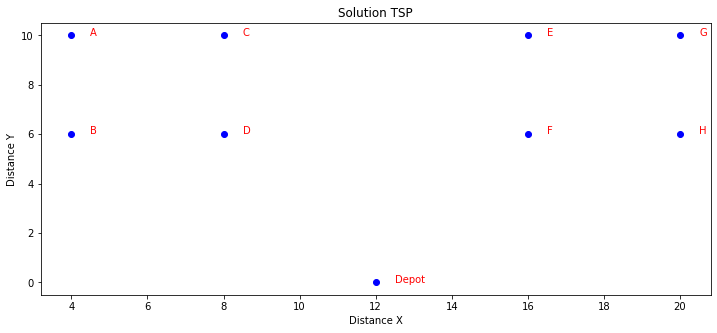

In [16]:
plt.figure(figsize=(12, 5))
plt.scatter(X, Y, color='blue')
  
for n in range(len(X)):
    plt.annotate(capitals[n], xy=(X[n], Y[n]),
                xytext=(X[n]+0.5, Y[n]), color='red')
    
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Solution TSP')

plt.show()

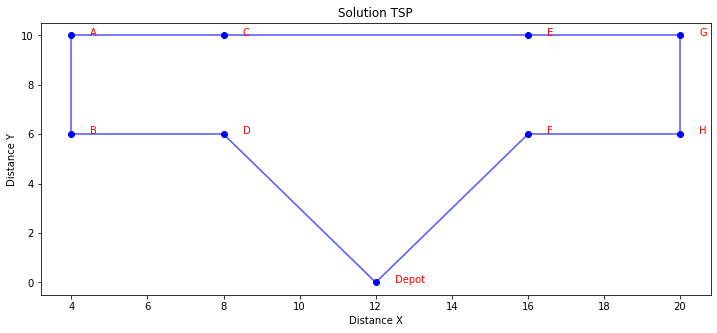

In [17]:
plt.figure(figsize=(12,5))

plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Solution TSP')

plt.scatter(x=X, y=Y, color='blue', zorder=1)


for city1, city2 in active_arcs:
    plt.plot([coordinates[city1][0], coordinates[city2][0]], [coordinates[city1][1], coordinates[city2][1]]
            , color='b', alpha=0.4, zorder=0)
    
# for i,j in active_arcs:
#     plt.plot([X[i], X[j]], [Y[i], Y[j]], color='b', alpha=0.4, zorder=0)
    
for n in range(len(X)):
    plt.annotate(capitals[n], xy=(X[n], Y[n]),
                xytext=(X[n]+0.5, Y[n]), color='red')
    
plt.show()    